##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [2]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

/bin/bash: wget: command not found


## Visualization utilities

In [3]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

In [4]:
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.png")
cv2_imshow(img)

/bin/bash: wget: command not found


ModuleNotFoundError: No module named 'google.colab'

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

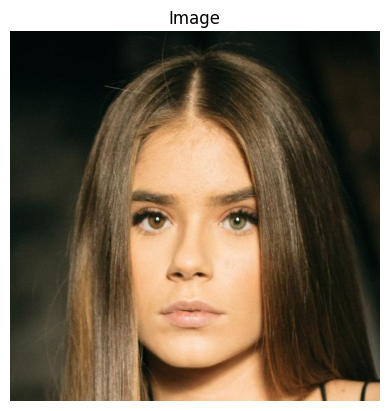

In [5]:
IMAGE_FILE = "Eye Detector V2/test/1-6838-_jpg.rf.4c5b68134ef020d3ab4ce0d59a80a22f.jpg"

import cv2
import matplotlib.pyplot as plt

# Load and display
img = cv2.imread(IMAGE_FILE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("Image")
plt.show()

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


I0000 00:00:1751735150.312035 5288194 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-23.0.26), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1751735150.312883 5288194 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1751735150.328456 5321275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751735150.390425 5321279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


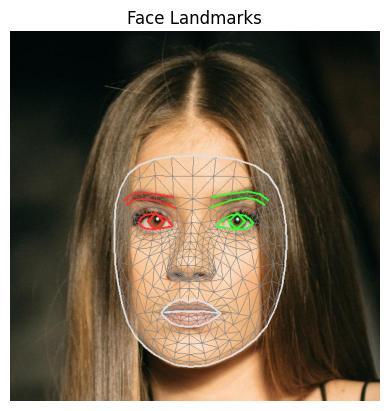

In [20]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

import cv2
rgb_image = image.numpy_view()
bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)

annotated_image = draw_landmarks_on_image(bgr_image, detection_result)

# STEP 5: Process the detection result. In this case, visualize it.
# annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  # convert back for display
plt.axis('off')
plt.title("Face Landmarks")
plt.show()

We will also visualize the face blendshapes categories using a bar graph.

In [ ]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [ ]:
print(detection_result.facial_transformation_matrixes)

In [59]:
import os
import cv2

left_eye_ids = [33, 133, 159, 160, 161, 144, 145, 153]
right_eye_ids = [362, 263, 386, 387, 388, 373, 374, 380]
pad = 10


image_folder = "test"
image_paths = [os.path.join(image_folder, f)
               for f in os.listdir(image_folder)
               if f.lower().endswith((".jpg"))]

for i, path in enumerate(image_paths):
    mp_image = mp.Image.create_from_file(path)
    detection_result = detector.detect(mp_image)

    if not detection_result.face_landmarks:
        print(f"❌ No face detected in {path}, skipping.")
        continue

    # Pick one detected face
    face_landmarks = detection_result.face_landmarks[0]
    
    rgb_image = mp_image.numpy_view()
    h, w, _ = rgb_image.shape
    
    xs = [int(face_landmarks[i].x * w) for i in left_eye_ids]
    ys = [int(face_landmarks[i].y * h) for i in left_eye_ids]

    xmin, xmax = max(min(xs) - pad, 0), min(max(xs) + pad, w)
    ymin, ymax = max(min(ys) - pad, 0), min(max(ys) + pad, h)
    
    # Crop the eye region from the original RGB image
    eye_crop = rgb_image[ymin:ymax, xmin:xmax]

    out_path = os.path.join("cropped_images/left", f"eye_{i}.png")
    cv2.imwrite(out_path, eye_crop)
    
    # Get right eye corners 
    xs = [int(face_landmarks[i].x * w) for i in right_eye_ids]
    ys = [int(face_landmarks[i].y * h) for i in right_eye_ids]

    xmin, xmax = max(min(xs) - pad, 0), min(max(xs) + pad, w)
    ymin, ymax = max(min(ys) - pad, 0), min(max(ys) + pad, h)
    
    # Crop the eye region from the original RGB image
    eye_crop = rgb_image[ymin:ymax, xmin:xmax]
    
    out_path = os.path.join("cropped_images/right", f"eye_{i}.png")
    cv2.imwrite(out_path, eye_crop)

❌ No face detected in test/1-6861-_jpg.rf.c2486a6253858e7c799a01c32cf26fb8.jpg, skipping.


In [ ]:
import os
import cv2

left_eye_ids = [33, 133, 159, 160, 161, 144, 145, 153]
right_eye_ids = [362, 263, 386, 387, 388, 373, 374, 380]
pad = 10


image_folder = "Eyedentify-AI/data/filtered/infected_eye"
image_paths = [os.path.join(image_folder, f)
               for f in os.listdir(image_folder)
               if f.lower().endswith((".jpg"))]

for i, path in enumerate(image_paths):
    mp_image = mp.Image.create_from_file(path)
    detection_result = detector.detect(mp_image)

    if not detection_result.face_landmarks:
        print(f"❌ No face detected in {path}, skipping.")
        continue

    # Pick one detected face
    face_landmarks = detection_result.face_landmarks[0]
    
    rgb_image = mp_image.numpy_view()
    h, w, _ = rgb_image.shape
    
    xs = [int(face_landmarks[i].x * w) for i in left_eye_ids]
    ys = [int(face_landmarks[i].y * h) for i in left_eye_ids]

    xmin, xmax = max(min(xs) - pad, 0), min(max(xs) + pad, w)
    ymin, ymax = max(min(ys) - pad, 0), min(max(ys) + pad, h)
    
    # Crop the eye region from the original RGB image
    eye_crop = rgb_image[ymin:ymax, xmin:xmax]

    out_path = os.path.join("cropped_images_infected/left", f"eye_{i}.png")
    cv2.imwrite(out_path, eye_crop)
    
    # Get right eye corners 
    xs = [int(face_landmarks[i].x * w) for i in right_eye_ids]
    ys = [int(face_landmarks[i].y * h) for i in right_eye_ids]

    xmin, xmax = max(min(xs) - pad, 0), min(max(xs) + pad, w)
    ymin, ymax = max(min(ys) - pad, 0), min(max(ys) + pad, h)
    
    # Crop the eye region from the original RGB image
    eye_crop = rgb_image[ymin:ymax, xmin:xmax]
    
    out_path = os.path.join("cropped_images_infected/right", f"eye_{i}.png")
    cv2.imwrite(out_path, eye_crop)

In [61]:
!ls

=2.4.0
=2.6.0
AppData
Applications
Applications (Parallels)
baltimorefoodline
car-counting-and-speed-estimation-yolo-sort-python
cookies.txt
cropped_images
cropped_images_infected
Desktop
dist
Documents
Downloads
eeg-mi.ipynb
ET7 Op.mp4
ET7-framets.npy
ExecutiveCoachApp
Eyedentify-AI
FLARe
flare-app
flare-portal
flare2
flask-birthday-reminder
GazeTracking
get-pip.py
git_flare_portal
ide-portfolio
IdeaProjects
IdeaSnapshots
Library
lucky-portfolio
main.spec
MARBLE
marble_X.npy
MARBLE.ipynb
Movies
Music
nextjs-ai-chatbot
nltk_data
node_modules
osd
package-lock.json
package.json
Pictures
pikaraoke
pnpm-lock.yaml
portfolio
Public
pupil_class_labels.npy
pyEnvs
README
semesterly
server.js
SIS-Bot
speed-detector
test
test.py
textbelt
TryOne.py
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Users
vs-code-style-site
Win


In [47]:
cd ./../

/Users/shiningdiamond


In [63]:
import os
import csv

# Define the paths to your two image folders
folder_1 = 'Eyedentify-AI/data/filtered/healthy_eye'  # Folder for class 0
folder_2 = 'Eyedentify-AI/data/filtered/infected_eye'  # Folder for class 0

# Generate the image paths and corresponding labels
image_paths = []
labels = []

# Add images from folder 1 (class 0)
for img_name in os.listdir(folder_1):
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image types
        image_paths.append(os.path.join(folder_1, img_name))
        labels.append(0)

# Add images from folder 2 (class 1)
for img_name in os.listdir(folder_2):
    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image types
        image_paths.append(os.path.join(folder_2, img_name))
        labels.append(1)

# Check if the labels and paths are generated correctly
print(f"Total images: {len(image_paths)}")
print(f"Labels: {labels[:10]}")  # Print first 10 labels for confirmation

# Define the file path for saving labels
labels_file = 'image_labels.csv'

# Save image paths and labels to a CSV file
with open(labels_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'label'])  # Header row
    for path, label in zip(image_paths, labels):
        writer.writerow([path, label])

print(f"Labels saved to {labels_file}")


Total images: 1295
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Labels saved to image_labels.csv


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from PIL import Image
import numpy as np
import random

# --- Reproducibility ---
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the path to your CSV file
csv_file = 'image_labels.csv'

# Initialize empty lists to hold the image paths and labels
image_paths = []
labels = []

# Read the CSV file and extract image paths and labels
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)  # Read the CSV into a dictionary
    for row in reader:
        image_paths.append(row['image_path'])
        labels.append(int(row['label']))  # Convert label to integer (0 or 1)

# Check the first few entries
print(f"Total images: {len(image_paths)}")
print(f"First 10 image paths: {image_paths[:10]}")
print(f"First 10 labels: {labels[:10]}")

# --- Custom Dataset ---
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# --- EarlyStopping Class ---
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path='best_model.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.save_path = save_path
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Cross-validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_metrics = {
    "val_loss": [],
    "val_auc": [],
    "val_accuracy": []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\n--- Fold {fold + 1} ---")
    train_dataset = EyeDataset([image_paths[i] for i in train_idx],
                               [labels[i] for i in train_idx],
                               transform=train_transform)
    val_dataset = EyeDataset([image_paths[i] for i in val_idx],
                             [labels[i] for i in val_idx],
                             transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # no sigmoid for BCEWithLogitsLoss
    model = model.to(device)

    # Freeze all but final layer
    for name, param in model.named_parameters():
        if not name.startswith('fc'):
            param.requires_grad = False

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    early_stopping = EarlyStopping(patience=5, save_path=f'best_model_fold{fold+1}.pt')

    best_loss, best_auc, best_acc = float('inf'), 0, 0

    for epoch in range(30):
        model.train()
        for imgs, labels_batch in train_loader:
            imgs, labels_batch = imgs.to(device), labels_batch.unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses, preds, truths = [], [], []
        with torch.no_grad():
            for imgs, labels_batch in val_loader:
                imgs, labels_batch = imgs.to(device), labels_batch.unsqueeze(1).to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels_batch)
                val_losses.append(loss.item())
                preds.extend(torch.sigmoid(outputs).cpu().numpy())
                truths.extend(labels_batch.cpu().numpy())

        val_loss = np.mean(val_losses)
        val_auc = roc_auc_score(truths, preds)
        val_acc = accuracy_score(np.array(truths) > 0.5, np.array(preds) > 0.5)
        print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}, AUC = {val_auc:.4f}, Accuracy = {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_auc = val_auc
            best_acc = val_acc

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    fold_metrics["val_loss"].append(best_loss)
    fold_metrics["val_auc"].append(best_auc)
    fold_metrics["val_accuracy"].append(best_acc)

# --- Results Summary ---
print("\n=== Cross-Validation Summary ===")
for key, values in fold_metrics.items():
    print(f"{key}: {np.mean(values):.4f} ± {np.std(values):.4f}")


Total images: 1295
First 10 image paths: ['Eyedentify-AI/data/filtered/healthy_eye/63.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/823.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/189.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/77.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/638.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/604.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/162.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/176.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/88.jpg', 'Eyedentify-AI/data/filtered/healthy_eye/610.jpg']
First 10 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--- Fold 1 ---


/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.6132, AUC = 0.7697, Accuracy = 0.6564
Epoch 2: Val Loss = 0.5711, AUC = 0.8630, Accuracy = 0.7027
Epoch 3: Val Loss = 0.5249, AUC = 0.9120, Accuracy = 0.7915
Epoch 4: Val Loss = 0.4794, AUC = 0.9469, Accuracy = 0.8378
Epoch 5: Val Loss = 0.4457, AUC = 0.9591, Accuracy = 0.8803
Epoch 6: Val Loss = 0.4201, AUC = 0.9658, Accuracy = 0.8842
Epoch 7: Val Loss = 0.4019, AUC = 0.9689, Accuracy = 0.8880
Epoch 8: Val Loss = 0.3759, AUC = 0.9734, Accuracy = 0.9035
Epoch 9: Val Loss = 0.3606, AUC = 0.9761, Accuracy = 0.8996
Epoch 10: Val Loss = 0.3427, AUC = 0.9792, Accuracy = 0.9151
Epoch 11: Val Loss = 0.3346, AUC = 0.9803, Accuracy = 0.9151
Epoch 12: Val Loss = 0.3137, AUC = 0.9821, Accuracy = 0.9228
Epoch 13: Val Loss = 0.3036, AUC = 0.9834, Accuracy = 0.9266
Epoch 14: Val Loss = 0.2977, AUC = 0.9832, Accuracy = 0.9266
Epoch 15: Val Loss = 0.2844, AUC = 0.9839, Accuracy = 0.9228
Epoch 16: Val Loss = 0.2764, AUC = 0.9850, Accuracy = 0.9305
Epoch 17: Val Loss = 0.2684, AUC 

/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.6464, AUC = 0.7201, Accuracy = 0.6448
Epoch 2: Val Loss = 0.5927, AUC = 0.8411, Accuracy = 0.7297
Epoch 3: Val Loss = 0.5492, AUC = 0.8984, Accuracy = 0.8031
Epoch 4: Val Loss = 0.5192, AUC = 0.9236, Accuracy = 0.8108
Epoch 5: Val Loss = 0.4884, AUC = 0.9357, Accuracy = 0.8803
Epoch 6: Val Loss = 0.4619, AUC = 0.9445, Accuracy = 0.8842
Epoch 7: Val Loss = 0.4413, AUC = 0.9491, Accuracy = 0.8880
Epoch 8: Val Loss = 0.4213, AUC = 0.9558, Accuracy = 0.8842
Epoch 9: Val Loss = 0.4058, AUC = 0.9600, Accuracy = 0.8958
Epoch 10: Val Loss = 0.3882, AUC = 0.9616, Accuracy = 0.8919
Epoch 11: Val Loss = 0.3771, AUC = 0.9638, Accuracy = 0.8958
Epoch 12: Val Loss = 0.3626, AUC = 0.9667, Accuracy = 0.8996
Epoch 13: Val Loss = 0.3526, AUC = 0.9677, Accuracy = 0.8958
Epoch 14: Val Loss = 0.3443, AUC = 0.9687, Accuracy = 0.8996
Epoch 15: Val Loss = 0.3299, AUC = 0.9700, Accuracy = 0.8996
Epoch 16: Val Loss = 0.3259, AUC = 0.9710, Accuracy = 0.8996
Epoch 17: Val Loss = 0.3147, AUC 

/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.7102, AUC = 0.6120, Accuracy = 0.6293
Epoch 2: Val Loss = 0.6389, AUC = 0.7800, Accuracy = 0.6834
Epoch 3: Val Loss = 0.5877, AUC = 0.8727, Accuracy = 0.7645
Epoch 4: Val Loss = 0.5455, AUC = 0.9120, Accuracy = 0.8031
Epoch 5: Val Loss = 0.5104, AUC = 0.9387, Accuracy = 0.8378
Epoch 6: Val Loss = 0.4743, AUC = 0.9541, Accuracy = 0.8803
Epoch 7: Val Loss = 0.4462, AUC = 0.9642, Accuracy = 0.8958
Epoch 8: Val Loss = 0.4196, AUC = 0.9690, Accuracy = 0.9112
Epoch 9: Val Loss = 0.3979, AUC = 0.9726, Accuracy = 0.8996
Epoch 10: Val Loss = 0.3764, AUC = 0.9753, Accuracy = 0.9035
Epoch 11: Val Loss = 0.3639, AUC = 0.9782, Accuracy = 0.9266
Epoch 12: Val Loss = 0.3438, AUC = 0.9789, Accuracy = 0.9189
Epoch 13: Val Loss = 0.3284, AUC = 0.9796, Accuracy = 0.9189
Epoch 14: Val Loss = 0.3198, AUC = 0.9830, Accuracy = 0.9382
Epoch 15: Val Loss = 0.3087, AUC = 0.9847, Accuracy = 0.9459
Epoch 16: Val Loss = 0.3017, AUC = 0.9846, Accuracy = 0.9228
Epoch 17: Val Loss = 0.2926, AUC 

/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.8002, AUC = 0.2224, Accuracy = 0.3861
Epoch 2: Val Loss = 0.7350, AUC = 0.3696, Accuracy = 0.4865
Epoch 3: Val Loss = 0.6726, AUC = 0.5592, Accuracy = 0.5869
Epoch 4: Val Loss = 0.6208, AUC = 0.7276, Accuracy = 0.6680
Epoch 5: Val Loss = 0.5742, AUC = 0.8423, Accuracy = 0.7683
Epoch 6: Val Loss = 0.5288, AUC = 0.9152, Accuracy = 0.8378
Epoch 7: Val Loss = 0.4952, AUC = 0.9487, Accuracy = 0.8764
Epoch 8: Val Loss = 0.4671, AUC = 0.9615, Accuracy = 0.9073
Epoch 9: Val Loss = 0.4397, AUC = 0.9715, Accuracy = 0.9189
Epoch 10: Val Loss = 0.4158, AUC = 0.9793, Accuracy = 0.9189
Epoch 11: Val Loss = 0.3933, AUC = 0.9829, Accuracy = 0.9266
Epoch 12: Val Loss = 0.3681, AUC = 0.9852, Accuracy = 0.9498
Epoch 13: Val Loss = 0.3568, AUC = 0.9869, Accuracy = 0.9537
Epoch 14: Val Loss = 0.3418, AUC = 0.9879, Accuracy = 0.9382
Epoch 15: Val Loss = 0.3198, AUC = 0.9896, Accuracy = 0.9537
Epoch 16: Val Loss = 0.3112, AUC = 0.9896, Accuracy = 0.9537
Epoch 17: Val Loss = 0.2959, AUC 

/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/cebra-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Loss = 0.6687, AUC = 0.6418, Accuracy = 0.6332
Epoch 2: Val Loss = 0.6178, AUC = 0.7891, Accuracy = 0.7143
Epoch 3: Val Loss = 0.5661, AUC = 0.8840, Accuracy = 0.7799
Epoch 4: Val Loss = 0.5258, AUC = 0.9276, Accuracy = 0.8340
Epoch 5: Val Loss = 0.4919, AUC = 0.9511, Accuracy = 0.8726
Epoch 6: Val Loss = 0.4638, AUC = 0.9634, Accuracy = 0.8764
Epoch 7: Val Loss = 0.4394, AUC = 0.9675, Accuracy = 0.8842
Epoch 8: Val Loss = 0.4183, AUC = 0.9707, Accuracy = 0.8919
Epoch 9: Val Loss = 0.4025, AUC = 0.9713, Accuracy = 0.8842
Epoch 10: Val Loss = 0.3817, AUC = 0.9744, Accuracy = 0.8880
Epoch 11: Val Loss = 0.3652, AUC = 0.9757, Accuracy = 0.8958
Epoch 12: Val Loss = 0.3566, AUC = 0.9750, Accuracy = 0.8958
Epoch 13: Val Loss = 0.3438, AUC = 0.9758, Accuracy = 0.8996
Epoch 14: Val Loss = 0.3335, AUC = 0.9762, Accuracy = 0.9073
Epoch 15: Val Loss = 0.3252, AUC = 0.9764, Accuracy = 0.9073
Epoch 16: Val Loss = 0.3154, AUC = 0.9766, Accuracy = 0.9073
Epoch 17: Val Loss = 0.3074, AUC 

In [70]:
# Save just the weights
torch.save(model.state_dict(), 'resnet18_weights.pth')